***

# <font color='blue'> Kaggle House Price Predict (November 2018) </font>

***

(https://www.kaggle.com/c/nayadsp0218)

In [93]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
import sklearn.ensemble as ensb 
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("train.csv", index_col=0)
data.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
0,120,RL,50.0,7175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2009,WD,145000
1,120,RH,34.0,4058,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2007,WD,133000


In [3]:
data.shape

(1616, 79)

first state of table: *** 1616 rows *** and ***79 columns***

***

## Simple model as baseline

In [4]:
def rmsle (y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

I take only the numeric columns:

In [5]:
df_numeric = data.select_dtypes(include="number").dropna()
df_numeric.shape

(1243, 37)

In [6]:
X = df_numeric.drop(columns='SalePrice')
y = df_numeric['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

((870, 36), (373, 36))

In [7]:
base_model = linear_model.Lasso()
base_model.fit(X_train, y_train)
y_train_predict = base_model.predict(X_train)
y_test_predict = base_model.predict(X_test)
print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

train rmsle =  0.16087
test rmsle  =  0.16888


In [8]:
type(y_test)

pandas.core.series.Series

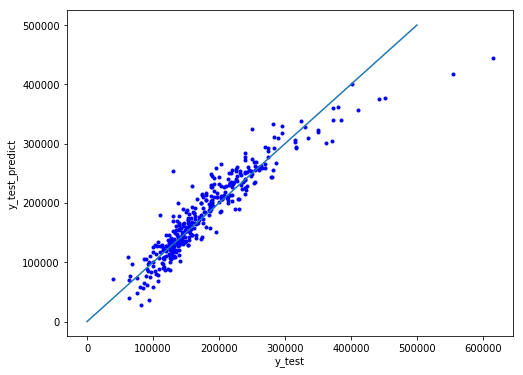

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(y_test, y_test_predict, '.b', [0, 500000], [0,500000], '-' )
ax.set_xlabel('y_test')
ax.set_ylabel('y_test_predict')
plt.show()

***

## Lets visualize

### takes only numeric features from all the data (no dropna):

In [10]:
df_numeric = data.drop(columns='SalePrice').select_dtypes(include='number')
df_numeric.shape

(1616, 36)

In [11]:
data['SalePrice'].shape

(1616,)

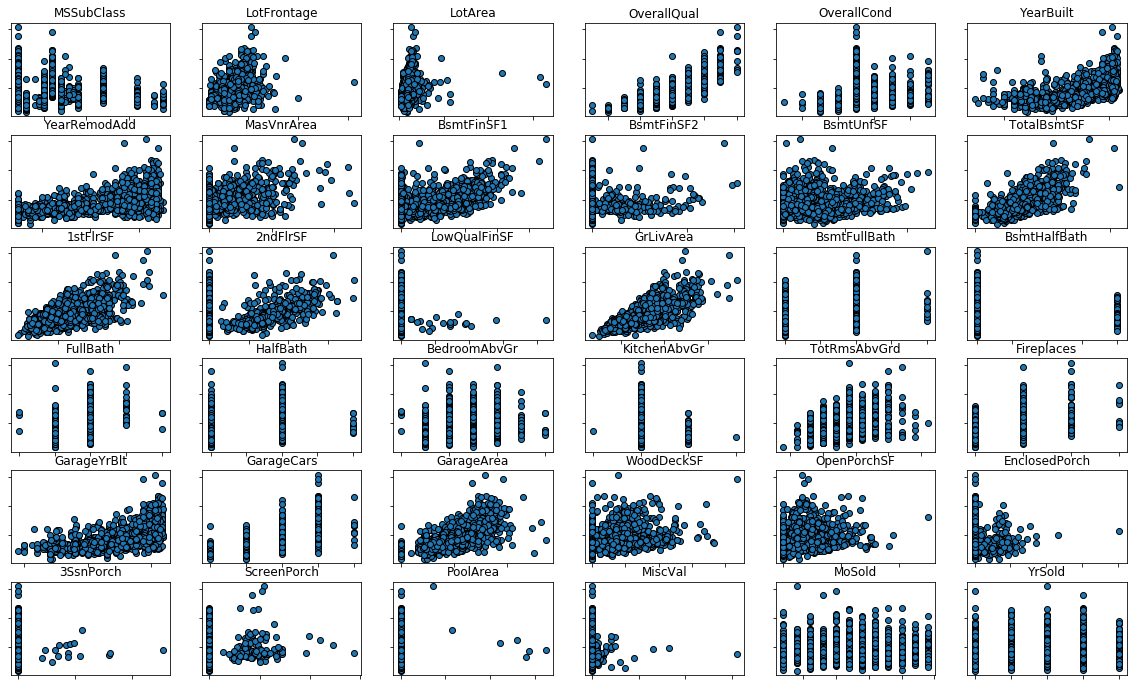

In [12]:
fig = plt.figure(figsize=(20,12))
for i in range(0, df_numeric.shape[1]):
    ax = fig.add_subplot(6,6,i+1)
    ax.scatter(x=df_numeric.iloc[:,i], y=data['SalePrice'], edgecolors='k')
    ax.set_title(df_numeric.columns[i])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


### Check indvidual numeric feature

The Nan rate: 0.18


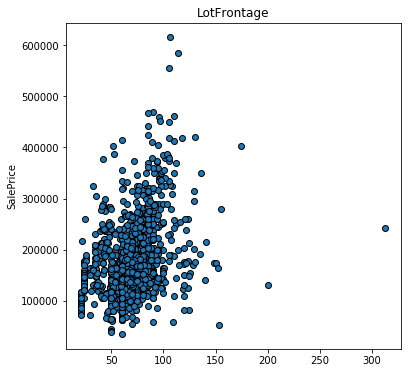

In [13]:
col = df_numeric.columns[1]

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(x=df_numeric[col], y=data['SalePrice'], edgecolors='k')
ax.set_title(col)
ax.set_ylabel('SalePrice')
#ax.set_xlim(0,16000) #limit the x Axis
print(f'The Nan rate: {(df_numeric[col].isnull().sum() / len(df_numeric[col])):.2f}')

Which numeric features should be included in the model:
----------------------------------------------------------
LotFrontage, OverallQual, YearBuilt,
BsmtFinSF1 (need to exclude 0 from the regression), 
TotalBsmtSF, 1stFlrSF, 
2ndFlrSF (need to exclude 0 from the regression)
GrLivArea, GarageYrBlt, GarageArea
Total: 10 features

### takes only Categorical features from all the data (no dropna):

In [14]:
df_cat  = data.drop(columns='SalePrice').select_dtypes(exclude='number')
df_cat.shape

(1616, 42)

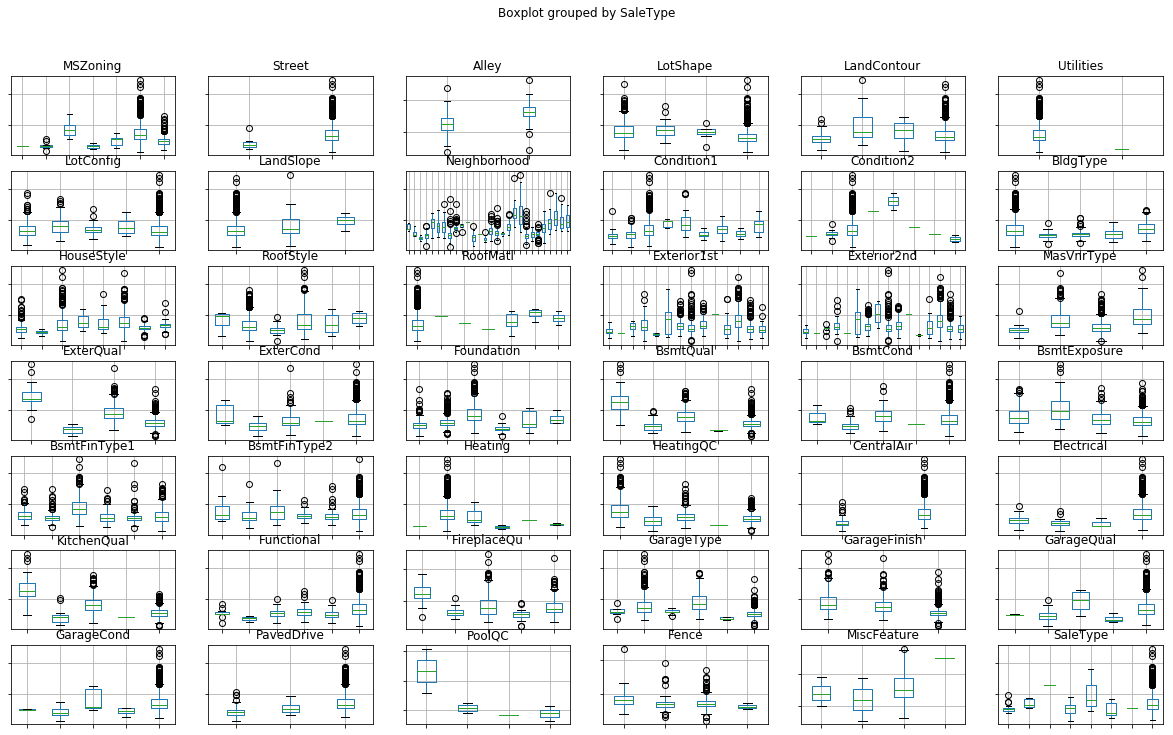

In [15]:
fig = plt.figure(figsize=(20,12))
for i in range(0,df_cat.shape[1]):
    ax = fig.add_subplot(7,6,i+1)
    col = df_cat.columns[i]
    data.boxplot(column='SalePrice', by=col, ax= ax)
    ax.set_title(col)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')

### Check indvidual categorial feature

The Nan rate: 0.00


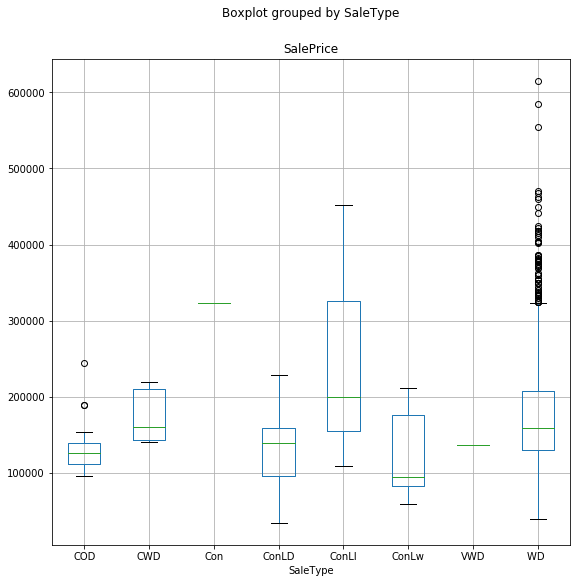

In [16]:
col = df_cat.columns[41]
data.boxplot(column='SalePrice', by=col, figsize=(9,9))
print(f'The Nan rate: {(df_cat[col].isnull().sum() / len(df_cat[col])):.2f}')
#df_cat[col].value_counts()

Which categorial features should be included in the model:
-------------------------------------------------------------
Street
Neighborhood
Condition1
Condition2
ExterQual
BsmtQual
CentralAir
KitchenQual
Total: 8 features

## Model for hand-hanled features

In [17]:
data.loc[: ,('LotFrontage','OverallQual','YearBuilt','1stFlrSF','GrLivArea','GarageYrBlt','GarageArea','SalePrice')].shape

(1616, 8)

In [18]:
data_prep = data.loc[: ,('LotFrontage','OverallQual','YearBuilt','1stFlrSF','GrLivArea','GarageYrBlt','GarageArea','SalePrice')].select_dtypes(include="number").dropna()

In [19]:
data_prep.shape

(1246, 8)

In [20]:
data_prep.head()

,LotFrontage,OverallQual,YearBuilt,1stFlrSF,GrLivArea,GarageYrBlt,GarageArea,SalePrice
Id,,,,,,,,
0,50.0,6,1990,1332,1332,1990.0,542.0,145000
1,34.0,7,1998,767,767,1998.0,367.0,133000
2,24.0,7,2004,970,1709,2004.0,380.0,130000
3,60.0,5,2005,734,1838,2005.0,372.0,192140
4,75.0,8,1972,2000,2704,1972.0,538.0,345000


In [21]:
X = data_prep.drop(columns='SalePrice')
y = data_prep['SalePrice']

abs_trans = StandardScaler()
X = abs_trans.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

((872, 7), (374, 7))

In [22]:
base_model = linear_model.Lasso()
base_model.fit(X_train, y_train)
y_train_predict = abs(base_model.predict(X_train))
y_test_predict = abs(base_model.predict(X_test))
print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

train rmsle =  0.24026
test rmsle  =  0.17464


## Handle numeric features:

### LotFrontage

In [23]:
#col = data.loc[:, 'LotFrontage']

The Nan rate: 0.18


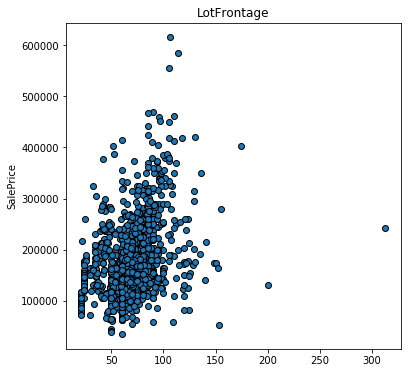

In [24]:
col = data_prep.columns[0]

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(x=data[col], y=data['SalePrice'], edgecolors='k')
ax.set_title(col)
ax.set_ylabel('SalePrice')
#ax.set_xlim(0,16000) #limit the x Axis
print(f'The Nan rate: {(df_numeric[col].isnull().sum() / len(df_numeric[col])):.2f}')

In [25]:
df_numeric[col].isnull().sum()

297

### Lets fill the nulls for column LotFrontage. using the target variable is the predictor

In [26]:
col_not_null = data.loc[data.LotFrontage.notnull()]
#col_not_null[col].isnull().sum()
col_null = data.loc[data.LotFrontage.isnull()]

X_col_not_null = col_not_null[['SalePrice']]
y_col_not_null = col_not_null[col]

linear_frame = linear_model.LinearRegression()
linear_mdl = linear_frame.fit(X = X_col_not_null, y = y_col_not_null)
#linear_model.coef_
#linear_model.intercept_
y_col_not_null_predict = linear_mdl.predict(X_col_not_null)

#fig = plt.figure(figsize=(3,3))
#ax = fig.gca()
#ax.scatter(x=X_col_not_null.values, y=y_col_not_null_predict, edgecolors='k')


In [27]:
X_col_null = col_null[['SalePrice']]
y_col_null_predict = linear_mdl.predict(X_col_null)
#fig = plt.figure(figsize=(3,3))
#ax = fig.gca()
#ax.scatter(x=X_col_null.values, y=y_col_null_predict, edgecolors='k')
X_col_null
y_col_null_predict
data.loc[X_col_null.index, col]  = y_col_null_predict

In [28]:
data.iloc[X_col_null.index][col].head(5)

Id
8     61.153085
11    70.864805
21    77.066264
22    63.551763
25    66.067449
Name: LotFrontage, dtype: float64

### Lets fill the nulls for column GarageYrBlt, using the other features as its predictor

The Nan rate: 0.05


76

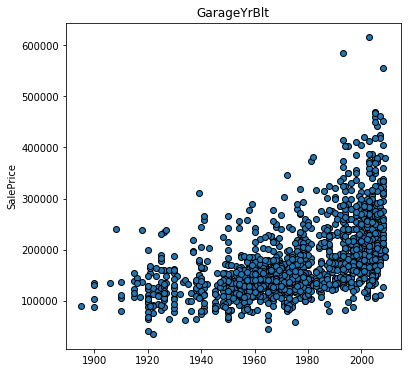

In [29]:
col = 'GarageYrBlt'

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(x=data[col], y=data['SalePrice'], edgecolors='k')
ax.set_title(col)
ax.set_ylabel('SalePrice')
#ax.set_xlim(0,16000) #limit the x Axis
print(f'The Nan rate: {(data[col].isnull().sum() / len(data[col])):.2f}')
data[col].isnull().sum()


In [30]:
data_predict = data.loc[: ,('LotFrontage','OverallQual','YearBuilt','1stFlrSF','GrLivArea','GarageYrBlt','GarageArea','SalePrice')]
col_not_null = data_predict.loc[data.GarageYrBlt.notnull()]
col_null = data_predict.loc[data.GarageYrBlt.isnull()]
#col_not_null['GarageYrBlt'].count() 
#len(col_null['GarageYrBlt']) + col_not_null['GarageYrBlt'].count() 

X_col_not_null = col_not_null.drop(['SalePrice','GarageYrBlt' ], axis = 1)
y_col_not_null = col_not_null.GarageYrBlt

In [31]:
classifier = RandomForestRegressor(n_estimators = 10, random_state=1234)

In [32]:
claffier_col = classifier.fit(X_col_not_null, y_col_not_null)

In [33]:

col_pred = claffier_col.predict(col_null.drop(['SalePrice','GarageYrBlt' ], axis = 1)).astype(int)

#### Assigning theimpute values to feature "GarageYrBlt"

In [34]:
data.loc[col_null.index, 'GarageYrBlt'] =  col_pred

### Lets handle the Nans of feature MasVnrArea

The Nan rate: 0.0043


994

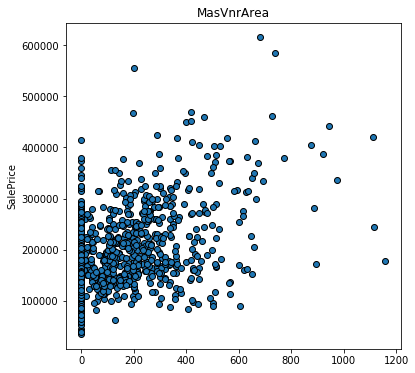

In [35]:
col = 'MasVnrArea'

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(x=data[col], y=data['SalePrice'], edgecolors='k')
ax.set_title(col)
ax.set_ylabel('SalePrice')
#ax.set_xlim(0,16000) #limit the x Axis
print(f'The Nan rate: {(data[col].isnull().sum() / len(data[col])):.4f}')
data[col].isnull().sum()
len(data[data.MasVnrArea==0])

#### There are too many 0's, so I omitt this feature from the training set

## Handle Categorial features:

### Lets fill the nulls for column GarageYrBlt, using the other features as its predictor

The Nan rate: 0.03


52

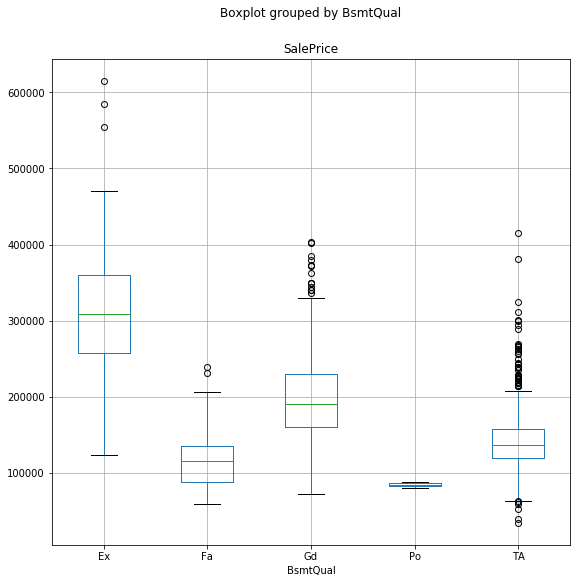

In [36]:
col = 'BsmtQual'
#col = df_cat.columns[41]
data.boxplot(column='SalePrice', by=col, figsize=(9,9))
print(f'The Nan rate: {(data[col].isnull().sum() / len(data[col])):.2f}')
data[col].isnull().sum()

In [37]:
explore = data.loc[data[col].isnull(), ['BsmtQual','SalePrice']]['SalePrice']
explore.describe()

count        52.000000
mean     101686.750000
std       33858.391388
min       39300.000000
25%       81875.000000
50%       98000.000000
75%      112750.000000
max      230000.000000
Name: SalePrice, dtype: float64

#### I decided to create a new catergory "Other" because the Nans value of column 'BsmtQual' have low std around itd mean.

In [38]:
data.loc[data[col].isnull(),col] = 'Others'
#data.loc[X_col_null.index, col]  = y_col_null_predict

The Nan rate: 0.00


0

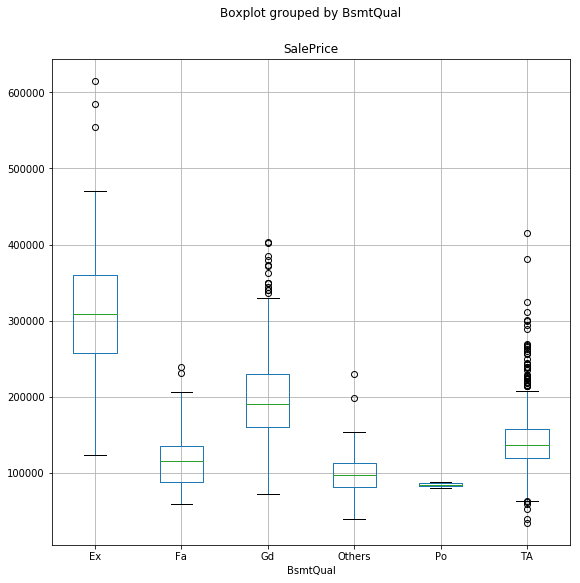

In [39]:
col = 'BsmtQual'
#col = df_cat.columns[41]
data.boxplot(column='SalePrice', by=col, figsize=(9,9))
print(f'The Nan rate: {(data[col].isnull().sum() / len(data[col])):.2f}')
data[col].isnull().sum()

### Lets handle the Nans of categirial feature Alley

In [40]:
col = 'Alley'
#col = df_cat.columns[41]
#data.boxplot(column='SalePrice', by=col, figsize=(9,9))
print(f'The Nan rate: {(data[col].isnull().sum() / len(data[col])):.2f}')
data[col].isnull().sum()

The Nan rate: 0.94


1517

#### its turned out that 94% of the samples of feature Alley are Nans, so we will remove this feature from the train set

### Lets handle the Nans of categirial feature MasVnrType

The Nan rate: 0.0043


7

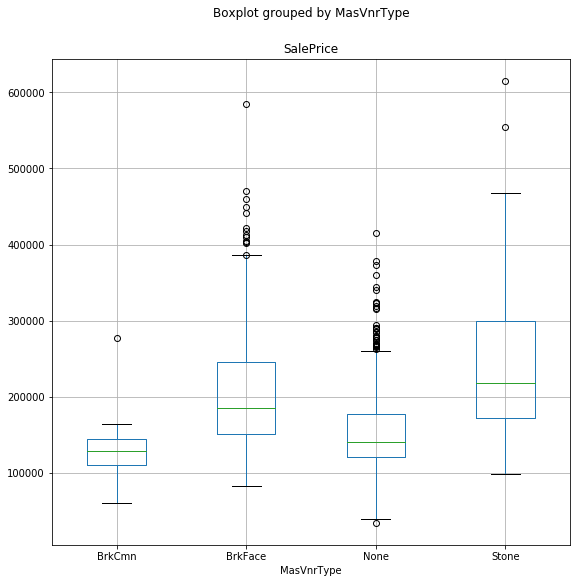

In [41]:
col = 'MasVnrType'
data.boxplot(column='SalePrice', by=col, figsize=(9,9))
print(f'The Nan rate: {(data[col].isnull().sum() / len(data[col])):.4f}')
data[col].isnull().sum()

In [42]:
data.loc[data.MasVnrType.isnull()].loc[:,('MasVnrType','SalePrice')]

,MasVnrType,SalePrice
Id,,
104,NaN,198500
256,NaN,247000
651,NaN,216500
888,NaN,205950
1198,NaN,117250
1306,NaN,257500
1464,NaN,165500


#### I decided to set these misiing valued to new class Other

In [43]:
data.loc[data[col].isnull(),col] = 'Others'

The Nan rate: 0.0000


0

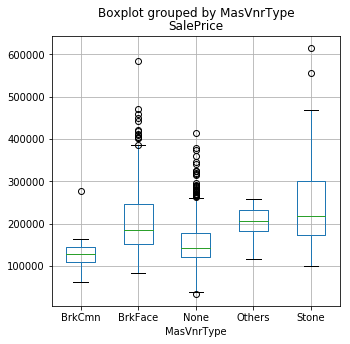

In [44]:
col = 'MasVnrType'
data.boxplot(column='SalePrice', by=col, figsize=(5,5))
print(f'The Nan rate: {(data[col].isnull().sum() / len(data[col])):.4f}')
data[col].isnull().sum()

***

## Lets try the handeled features with Lasso model

In [45]:
my_features = data.loc[: ,('Street','Neighborhood','Condition1','Condition2','ExterQual','BsmtQual','CentralAir','KitchenQual','LotFrontage','OverallQual','YearBuilt','1stFlrSF','TotalBsmtSF','GrLivArea','GarageYrBlt','GarageArea','SalePrice')]
my_features.shape

(1616, 17)

In [46]:
X = pd.get_dummies(my_features.drop(columns='SalePrice'))
y = my_features['SalePrice']

#abs_trans = StandardScaler()
#X = abs_trans.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

((1131, 72), (485, 72))

In [47]:
X_train.head()

,LotFrontage,OverallQual,YearBuilt,1stFlrSF,TotalBsmtSF,GrLivArea,GarageYrBlt,GarageArea,Street_Grvl,Street_Pave,...,BsmtQual_Others,BsmtQual_Po,BsmtQual_TA,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA
Id,,,,,,,,,,,,,,,,,,,,,
403,60.000000,5,1950,988,876.0,988,1950.0,276.0,0,1,...,0,0,1,0,1,0,0,0,0,1
745,58.000000,5,1922,1048,993.0,1048,1922.0,280.0,0,1,...,0,0,1,0,1,0,0,0,0,1
1332,51.000000,7,2007,1569,1386.0,1569,2007.0,660.0,0,1,...,0,0,0,0,1,0,0,1,0,0
862,73.000000,7,1996,1504,1504.0,1504,1996.0,478.0,0,1,...,0,0,0,0,1,0,0,1,0,0
1206,67.354545,5,1954,1383,1383.0,1383,1954.0,354.0,0,1,...,0,0,0,0,1,0,0,0,0,1


In [48]:
my_features_model = linear_model.Lasso(alpha=23.0, normalize = True)
my_features_model.fit(X_train, y_train)
y_train_predict = abs(my_features_model.predict(X_train))
y_test_predict = abs(my_features_model.predict(X_test))
print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

train rmsle =  0.15304
test rmsle  =  0.15300


the base model results were:
train rmsle =  0.16087
test rmsle  =  0.16888

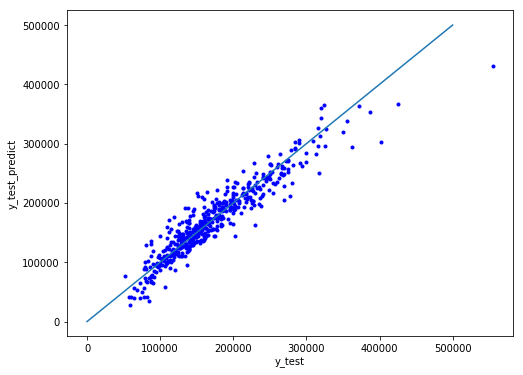

In [49]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(y_test, y_test_predict, '.b', [0, 500000], [0,500000], '-' )
ax.set_xlabel('y_test')
ax.set_ylabel('y_test_predict')
plt.show()

### I try now polynial model since the above picture suggest there is non linear relation between the true result and the prdicted ones

In [50]:
poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X2 = poly.fit_transform(X)

In [51]:
y = my_features['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

((1131, 2700), (485, 2700))

In [52]:
my_features_model = linear_model.Ridge(alpha=1.0, normalize = True)
my_features_model.fit(X_train, y_train)
y_train_predict = abs(my_features_model.predict(X_train))
y_test_predict = abs(my_features_model.predict(X_test))
print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

train rmsle =  0.10174
test rmsle  =  0.12631


In [53]:
my_features_model = ensb.RandomForestRegressor(max_depth=10)
my_features_model.fit(X_train, y_train)
y_train_predict = abs(my_features_model.predict(X_train))
y_test_predict = abs(my_features_model.predict(X_test))
print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

train rmsle =  0.06845
test rmsle  =  0.12008


### Lets try to improve it by using Pipeline and using Variance

In [54]:
def visualize_predictions2(model, X, y):
    y_pred = model.predict(X)
    residuals = y_pred - y
    y_max = max(y.max(), y_pred.max())
    
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    ax1.scatter(x=y, y=y_pred, label='Data', edgecolor='k', s=20)
    ax1.plot([0, y_max], [0, y_max], label='Ideal')
    ax1.set_title('pred vs actual')
    ax1.set_aspect('equal')

    ax2 = fig.add_subplot(122)
    ax2.plot(residuals, linestyle=' ', marker='o')
    ax2.set_aspect('equal')
    ax2.set_title('residuals')

train rmsle =  0.11201
test rmsle  =  0.12432


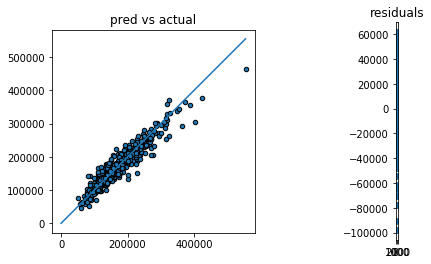

In [55]:
y = my_features['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

pipe = Pipeline([('poly', PolynomialFeatures(2, interaction_only=False, include_bias=False)),('var',VarianceThreshold(0.5)),('model', linear_model.Ridge(alpha=1.0, normalize = True))])
pipe.fit(X_train, y_train)

y_train_predict   = pipe.predict(X_train)
y_test_predict = pipe.predict(X_test)

print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

visualize_predictions2(pipe, X_test, y_test)

### Lets try the above model with the numeric features from the base model

In [56]:
df_numeric2 = data.select_dtypes(include="number").dropna()
df_numeric2.shape

(1609, 37)

In [57]:
X = df_numeric2.drop(columns='SalePrice')
y = df_numeric2['SalePrice']

train rmsle =  0.10737
test rmsle  =  0.12255


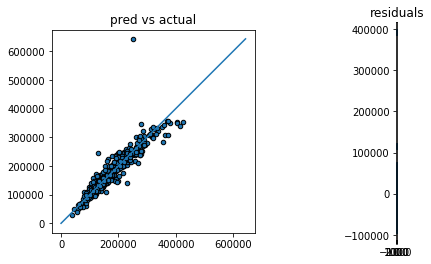

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

pipe = Pipeline([('poly', PolynomialFeatures(2, interaction_only=False, include_bias=False)),('var',VarianceThreshold(0.01)),('model', linear_model.Ridge(alpha=1.0, normalize = True))])
pipe.fit(X_train, y_train)

y_train_predict   = pipe.predict(X_train)
y_test_predict = pipe.predict(X_test)

print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

visualize_predictions2(pipe, X_test, y_test)

### So lets implemnent feature selection in order to use the best features for the model

### therefore we shoud use all the features and let VarianceThreshold to decise which one will be included in the model.

In [59]:
not_num_cols = []
for col in data.columns:
    if data[col].isnull().sum() > 0:
        not_num_cols.append(col)
not_num_cols

['Alley',
 'MasVnrArea',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [60]:
not_nan_features = data.loc[: ,('MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SalePrice')]
not_nan_features.shape

(1616, 64)

In [61]:
X = pd.get_dummies(not_nan_features.drop(columns='SalePrice'))
y = not_nan_features['SalePrice']

train rmsle =  0.09104
test rmsle  =  0.10362


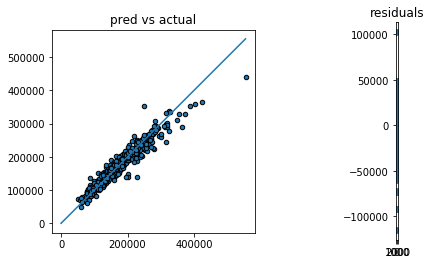

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

pipe = Pipeline([('poly', PolynomialFeatures(2, interaction_only=False, include_bias=False)),('var',VarianceThreshold(1)),('model', linear_model.Ridge(alpha=15.0, normalize = True))])
pipe.fit(X_train, y_train)

y_train_predict   = pipe.predict(X_train)
y_test_predict = pipe.predict(X_test)

print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

visualize_predictions2(pipe, X_test, y_test)

In [63]:
p = pipe.named_steps['poly']
v = pipe.named_steps['var']
m = pipe.named_steps['model']
len(p.get_feature_names()), len(v.variances_), sum(v.variances_>2), len(m.coef_)

(25199, 25199, 4383, 4532)

### Lets try to select fewer variables using Random Forest model:

In [64]:
X = pd.get_dummies(data.drop(columns= ['SalePrice','Alley','MasVnrArea']))
y = data['SalePrice']
names = X.columns
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)
#print("Features sorted by their score:")
#print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
#             reverse=True))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### check the number of features i would like to use for the analysis

In [65]:
len([(n, m) for n, m in list(zip(map(lambda x: round(x, 4), rf.feature_importances_),names)) if n>=0.0001])

173

In [66]:
most_influence_features = list(map(lambda x: x[1], sorted(list(zip(map(lambda x: round(x, 4), rf.feature_importances_),names)), reverse=True)))[:163]

In [67]:
nan_features = []
for col in data.columns:
    if data[col].isnull().sum() > 0:
        nan_features.append(col)

In [264]:
#verify that only not nan features are in the set of features
features_to_use=([feature for feature in most_influence_features if feature not in nan_features])
#features_to_use.append('SalePrice')

In [69]:
df_randomforest_selection = X.loc[: ,features_to_use]

In [70]:
df_randomforest_selection.shape

(1616, 163)

In [71]:
df_randomforest_selection['SalePrice'] = data.SalePrice

In [72]:
df_randomforest_selection.head()

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF,GarageCars,BsmtFinSF1,LotArea,LotFrontage,YearBuilt,...,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior1st_Plywood,Exterior1st_HdBoard,Exterior1st_CemntBd,ExterCond_Fa,Electrical_SBrkr,Electrical_FuseA,Condition1_Feedr,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
0,6,1332,542.0,1332.0,1332,2.0,0.0,7175,50.0,1990,...,0,0,1,0,0,0,1,0,0,145000
1,7,767,367.0,723.0,767,1.0,584.0,4058,34.0,1998,...,0,0,0,0,0,0,1,0,0,133000
2,7,1709,380.0,970.0,970,2.0,0.0,2522,24.0,2004,...,0,0,0,0,0,0,1,0,0,130000
3,5,1838,372.0,732.0,734,2.0,0.0,21930,60.0,2005,...,0,0,0,0,0,0,1,0,0,192140
4,8,2704,538.0,1952.0,2000,2.0,1410.0,13860,75.0,1972,...,0,0,1,0,0,0,1,0,0,345000


#### Lets try the model after the feature selection by RandomForestRegressor

In [203]:
X = df_randomforest_selection.drop(columns='SalePrice')
y = df_randomforest_selection['SalePrice']

train rmsle =  0.06948
test rmsle  =  0.09664


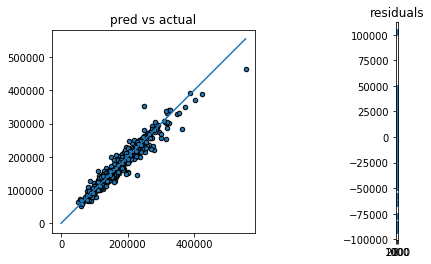

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

pipe = Pipeline([('poly', PolynomialFeatures(2, interaction_only=False, include_bias=False)),('var',VarianceThreshold(0.7)),('model', linear_model.Ridge(alpha=2.0, normalize = True))])
pipe.fit(X_train, y_train)

y_train_predict   = pipe.predict(X_train)
y_test_predict = pipe.predict(X_test)

print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

visualize_predictions2(pipe, X_test, y_test)

In [205]:
X_test.shape

(485, 163)

its better results from my previous tries [test rmsle  =  0.09432]..

## Lets see if PCA improves the results:

In [80]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [89]:
scaled_pca_transformer = PCA(n_components=80).fit(X_train_scaled)

In [90]:
X_train_scaled_pca = scaled_pca_transformer.transform(X_train_scaled)

In [91]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled_pca = scaled_pca_transformer.transform(X_test_scaled)

train rmsle =  0.08579
test rmsle  =  0.17499


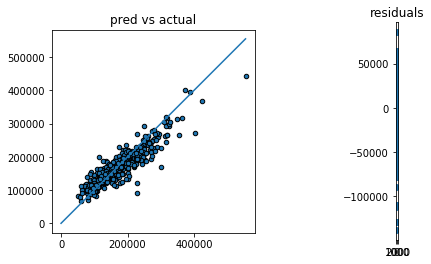

In [92]:
pipe = Pipeline([('poly', PolynomialFeatures(2, interaction_only=False, include_bias=False)),('var',VarianceThreshold(0.5)),('model', linear_model.Ridge(alpha=1.0, normalize = True))])
pipe.fit(X_train_scaled_pca, y_train)

y_train_predict   = pipe.predict(X_train_scaled_pca)
y_test_predict = pipe.predict(X_test_scaled_pca)

print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

visualize_predictions2(pipe, X_test_scaled_pca, y_test)

It is not improve the model, so i am not going to use in the model.

## Lets try GridSearch to improve our model

In [ ]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

pipe = Pipeline([('poly', PolynomialFeatures(2, interaction_only=False, include_bias=False)),('var',VarianceThreshold()),('model', linear_model.Ridge(normalize = True))])

parameters = {
    'var__threshold': list(frange(0.001, 0.1, 0.005)),
    'model__alpha': range(1,5,1)}

grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('var', VarianceThreshold(threshold=0.0)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'var__threshold': [0.001, 0.006, 0.011, 0.016, 0.021, 0.026000000000000002, 0.031000000000000003, 0.036000000000000004, 0.041, 0.046, 0.051, 0.055999999999999994, 0.06099999999999999, 0.06599999999999999, 0.071, 0.076, 0.081, 0.08600000000000001, 0.09100000000000001, 0.09600000000000002], 'model__alpha': range(1, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
grid_search.best_params_

{'model__alpha': 2, 'var__threshold': 0.001}

train rmsle =  0.04287
test rmsle  =  0.10176


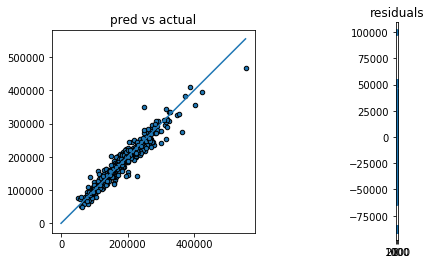

In [122]:
y_train_predict   = grid_search.predict(X_train)
y_test_predict = grid_search.predict(X_test)

print(f'train rmsle =  {rmsle(y_train, y_train_predict):.5f}')
print(f'test rmsle  =  {rmsle(y_test, y_test_predict):.5f}')

visualize_predictions2(grid_search, X_test, y_test)

### The fiiting by grid_search don't improve much, so i'll use my best model Ridge, with hyperparameter VarianceThreshold = 0.7 and alpha=2.0

***

## Produce the test set for the compatition

In [149]:
test_data = pd.read_csv("test.csv", index_col=0)
test_data.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType
Id,,,,,,,,,,,,,,,,,,,,,
1616,20,RL,62.0,9858,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,GdWo,Shed,600,11,2009,WD
1617,190,RL,62.0,10106,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,9,2008,WD


### take features with NaNs that will be used in the model :

In [157]:
num_cols = []
for col in test_data:
    if test_data[col].isnull().sum() > 0 and col in features_to_use:
        num_cols.append(col)
num_cols

['LotFrontage', 'BsmtFullBath', 'GarageYrBlt']

### taking care of the nulls of LotFrontage

In [165]:
data_predict = test_data.loc[: ,('LotFrontage','OverallQual','YearBuilt','1stFlrSF','GrLivArea','GarageArea')]
col_not_null = data_predict.loc[test_data.LotFrontage.notnull()]
col_null = data_predict.loc[test_data.LotFrontage.isnull()]

X_col_not_null = col_not_null.drop(['LotFrontage' ], axis = 1)
y_col_not_null = col_not_null.LotFrontage


In [166]:
classifier = RandomForestRegressor(n_estimators = 10, random_state=1234)
claffier_col = classifier.fit(X_col_not_null, y_col_not_null)
col_pred = claffier_col.predict(col_null.drop(['LotFrontage'], axis = 1)).astype(int)

In [167]:
test_data.loc[col_null.index, 'LotFrontage'] =  col_pred

In [168]:
data_predict.loc[test_data.LotFrontage.isnull()]

,LotFrontage,OverallQual,YearBuilt,1stFlrSF,GrLivArea,GarageArea
Id,,,,,,


### taking care of the nulls of GarageYrBlt

In [169]:
data_predict = test_data.loc[: ,('LotFrontage','OverallQual','YearBuilt','1stFlrSF','GrLivArea','GarageArea','GarageYrBlt')]
col_not_null = data_predict.loc[test_data.GarageYrBlt.notnull()]
col_null = data_predict.loc[test_data.GarageYrBlt.isnull()]

X_col_not_null = col_not_null.drop(['GarageYrBlt' ], axis = 1)
y_col_not_null = col_not_null.GarageYrBlt

In [172]:
col_null.head(2)

,LotFrontage,OverallQual,YearBuilt,1stFlrSF,GrLivArea,GarageArea,GarageYrBlt
Id,,,,,,,
1617,62.0,5,1940,808,1355,0.0,NaN
1642,63.0,7,2006,1143,1143,0.0,NaN


In [171]:
classifier = RandomForestRegressor(n_estimators = 10, random_state=1234)
claffier_col = classifier.fit(X_col_not_null, y_col_not_null)
col_pred = claffier_col.predict(col_null.drop(['GarageYrBlt'], axis = 1)).astype(int)

In [174]:
test_data.loc[col_null.index, 'GarageYrBlt'] =  col_pred

In [175]:
data_predict.loc[test_data.GarageYrBlt.isnull()]

,LotFrontage,OverallQual,YearBuilt,1stFlrSF,GrLivArea,GarageArea,GarageYrBlt
Id,,,,,,,


### taking care of BsmtFullBath

In [179]:
test_data.loc[test_data.BsmtFullBath.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType
Id,,,,,,,,,,,,,,,,,,,,,
2093,20,RL,123.0,47007,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,7,2008,WD


In [189]:
test_data.loc[2093, 'BsmtFullBath'] = 0.0

In [190]:
test_data.loc[2093]['BsmtFullBath'] 

0.0

### Run the model for the test data

In [266]:
X = pd.get_dummies(test_data.drop(columns= ['Alley','MasVnrArea']))

In [267]:
df_test_data = X.loc[: ,features_to_use]

C:\Users\guda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
C:\Users\guda\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [268]:
X_features = list(X.columns)
for feature in features_to_use:
    if feature not in X_features:
        df_test_data.loc[:, feature] = 0
        print(f'the feature {feature} is not exist in the test data and therefore was got 0')

the feature BsmtQual_Others is not exist in the test data and therefore was got 0
the feature Exterior2nd_PreCast is not exist in the test data and therefore was got 0
the feature Exterior1st_PreCast is not exist in the test data and therefore was got 0


In [269]:
df_test_data.shape

(796, 163)

In [270]:
df_test_data.iloc[:10,:]

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF,GarageCars,BsmtFinSF1,LotArea,LotFrontage,YearBuilt,...,Exterior2nd_HdBoard,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior1st_Plywood,Exterior1st_HdBoard,Exterior1st_CemntBd,ExterCond_Fa,Electrical_SBrkr,Electrical_FuseA,Condition1_Feedr
Id,,,,,,,,,,,,,,,,,,,,,
1616,5,874,288.0,864.0,874,1.0,510.0,9858,62.0,1968,...,1,0,0,0,1,0,0,1,0,0
1617,5,1355,0.0,644.0,808,0.0,351.0,10106,62.0,1940,...,0,0,0,0,0,0,0,1,0,0
1618,6,1882,612.0,0.0,964,2.0,0.0,8250,75.0,1981,...,0,0,0,0,0,0,0,1,0,0
1619,4,1040,420.0,0.0,1040,2.0,0.0,7200,60.0,1949,...,0,0,0,0,0,0,0,0,0,0
1620,5,816,264.0,816.0,816,1.0,546.0,8314,76.0,1982,...,0,0,0,0,1,0,0,1,0,0
1621,6,1797,616.0,1152.0,1152,2.0,944.0,12961,74.0,1993,...,0,0,0,0,0,0,0,1,0,0
1622,4,630,286.0,630.0,630,1.0,509.0,1477,21.0,1970,...,0,1,0,0,0,1,0,1,0,0
1623,5,1114,576.0,1114.0,1114,2.0,646.0,13695,66.0,2004,...,0,0,0,0,0,0,0,1,0,0
1624,7,1948,434.0,847.0,847,2.0,0.0,7875,63.0,2003,...,0,0,0,0,0,0,0,1,0,0


In [271]:
X_test.iloc[:10,:]

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF,GarageCars,BsmtFinSF1,LotArea,LotFrontage,YearBuilt,...,Exterior2nd_HdBoard,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior1st_Plywood,Exterior1st_HdBoard,Exterior1st_CemntBd,ExterCond_Fa,Electrical_SBrkr,Electrical_FuseA,Condition1_Feedr
Id,,,,,,,,,,,,,,,,,,,,,
1018,7,1320,400.0,660.0,660,2.0,0.0,7750,67.003519,2003,...,0,0,0,0,0,0,0,1,0,0
21,7,1850,467.0,973.0,979,2.0,595.0,29959,77.066264,1994,...,1,0,0,0,1,0,0,1,0,0
1180,6,1090,240.0,720.0,760,1.0,0.0,6000,60.000000,1940,...,0,0,0,0,0,0,0,1,0,0
6,7,1829,613.0,941.0,941,2.0,483.0,9548,44.000000,2003,...,0,0,0,0,0,0,0,1,0,0
508,8,1324,550.0,1324.0,1324,2.0,863.0,6240,48.000000,2006,...,0,0,0,0,0,0,0,1,0,0
891,8,1338,582.0,1338.0,1338,2.0,616.0,4920,41.000000,2001,...,0,1,0,0,0,1,0,1,0,0
273,5,941,564.0,941.0,941,2.0,941.0,8604,75.000000,1978,...,0,0,0,1,0,0,0,1,0,0
1424,5,816,264.0,816.0,816,1.0,534.0,6490,59.000000,1983,...,0,0,0,0,0,0,0,1,0,0
816,6,1560,400.0,684.0,684,2.0,0.0,11911,122.000000,2005,...,0,0,0,0,0,0,0,1,0,0


In [272]:
y_submit_test_predict = pipe.predict(df_test_data)

In [275]:
df_test_data['PredictedPrice'] = y_submit_test_predict

In [301]:
to_csv = pd.DataFrame(df_test_data.loc[:, ('PredictedPrice')])

In [305]:
to_csv.columns= ['SalePrice']

In [308]:
to_csv.to_csv('HousePricePredict1.csv')